# Citi Bike × NYPD: Usage patterns + insurer decision assets

This notebook is built to work with the repo Make targets (e.g. `make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"`).

It **always prefers the current run** (your `summaries/<RUN_TAG>/` folder) when you pass `YEARS/MONTHS`, so the report reflects exactly what you ingested.


## How to run (recommended)

From the repo root:

```bash
make all-both YEARS="YYYY YYYY..." MONTHS="1 2 .. 12" PURGE_OLD_ZIPS=NO 
check README
```

The Makefile sets environment variables (e.g. `CITIBIKE_PARQUET_DIR`, `CITIBIKE_YEARS`, `CITIBIKE_MONTHS`) which this notebook reads.


In [1]:
# --- Setup (STRICT + explicit risk variants): repo paths, run dirs, safe CSV loads ---

from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Optional display in notebooks
try:
    from IPython.display import display, Markdown
except Exception:
    display = print
    Markdown = lambda x: x

# nbconvert-friendly
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass
plt.ioff()

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Makefile").exists():
            return p
    raise FileNotFoundError(
        "Could not find repo root (Makefile) by walking up from:\n"
        f"  CWD={Path.cwd().resolve()}"
    )

def _parse_int_list(val: str | None):
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    parts = re.split(r"[,\s]+", s)
    out = []
    for p in parts:
        if not p:
            continue
        try:
            out.append(int(p))
        except Exception:
            pass
    return out or None

def read_csv_strict(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing required CSV: {path}")
    return pd.read_csv(path)

def read_csv_optional(path: Path) -> pd.DataFrame | None:
    return pd.read_csv(path) if path.exists() else None

REPO_ROOT = find_repo_root(Path.cwd())
SUMMARIES_ROOT = REPO_ROOT / "summaries"

PARQUET_DIR_ENV = (os.environ.get("CITIBIKE_PARQUET_DIR") or "").strip()
RUN_DIR_ENV     = (os.environ.get("CITIBIKE_RUN_DIR") or "").strip()
MODE_ENV        = (os.environ.get("CITIBIKE_MODE") or os.environ.get("MODE") or "").strip().lower()

YEARS_FILTER  = _parse_int_list(os.environ.get("CITIBIKE_YEARS")  or os.environ.get("YEARS"))
MONTHS_FILTER = _parse_int_list(os.environ.get("CITIBIKE_MONTHS") or os.environ.get("MONTHS"))

PARQUET_DIR = Path(PARQUET_DIR_ENV) if PARQUET_DIR_ENV else Path()

if RUN_DIR_ENV:
    RUN_DIR = Path(RUN_DIR_ENV)
else:
    run_tag = PARQUET_DIR.name if str(PARQUET_DIR).strip() else ""
    RUN_DIR = (SUMMARIES_ROOT / run_tag) if run_tag else Path()

# Resolve relative paths against repo root
if str(RUN_DIR).strip() and (not RUN_DIR.is_absolute()):
    RUN_DIR = (REPO_ROOT / RUN_DIR).resolve()
if str(PARQUET_DIR).strip() and (not PARQUET_DIR.is_absolute()):
    PARQUET_DIR = (REPO_ROOT / PARQUET_DIR).resolve()

# Strict folder checks
if not SUMMARIES_ROOT.exists():
    raise FileNotFoundError(f"Expected summaries/ at: {SUMMARIES_ROOT} (run make summarize first)")

if not RUN_DIR.exists():
    raise FileNotFoundError(f"RUN_DIR not found: {RUN_DIR} (run make summarize first)")

if str(PARQUET_DIR).strip() and (not PARQUET_DIR.exists()):
    raise FileNotFoundError(f"PARQUET_DIR not found: {PARQUET_DIR} (run make ingest first)")

# Required run CSVs
REQUIRED_RUN_FILES = [
    "citibike_trips_by_year.csv",
    "citibike_trips_by_month.csv",
    "citibike_trips_by_dow.csv",
    "citibike_trips_by_hour.csv",
]
missing = [f for f in REQUIRED_RUN_FILES if not (RUN_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        f"Missing required summary CSVs in:\n  {RUN_DIR}\nMissing: {missing}\n"
        "Run: make summarize-only (or make summarize / make all)."
    )

print("REPO_ROOT:", REPO_ROOT)
print("RUN_DIR:", RUN_DIR)
print("PARQUET_DIR:", PARQUET_DIR if str(PARQUET_DIR).strip() else "(not set)")
print("MODE (env):", MODE_ENV or "(not set)")
print("YEARS_FILTER:", YEARS_FILTER, "MONTHS_FILTER:", MONTHS_FILTER)

# Figures folder
FIG_DIR = REPO_ROOT / "reports" / RUN_DIR.name / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)

def savefig(filename: str):
    out = FIG_DIR / filename
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

# Load per-run summaries
df_year  = read_csv_strict(RUN_DIR / "citibike_trips_by_year.csv")
df_month = read_csv_strict(RUN_DIR / "citibike_trips_by_month.csv")
df_dow   = read_csv_strict(RUN_DIR / "citibike_trips_by_dow.csv")
df_hour  = read_csv_strict(RUN_DIR / "citibike_trips_by_hour.csv")

# Optional per-run outputs
df_station = read_csv_optional(RUN_DIR / "citibike_station_exposure.csv")

# Risk variants (overall + new per-year/per-month if present)
df_risk_overall = read_csv_optional(RUN_DIR / "station_risk_exposure_plus_crashproximity.csv")
df_risk_year    = read_csv_optional(RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year.csv")
df_risk_ym      = read_csv_optional(RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year_month.csv")

# Backward compat: keep df_risk pointing to "best available"
df_risk = df_risk_year if df_risk_year is not None else df_risk_overall

# Mode detection
mode = (
    str(df_year["mode"].iloc[0]).lower()
    if ("mode" in df_year.columns and len(df_year))
    else (MODE_ENV or "unknown")
)
print("Detected mode:", mode)

# Apply optional filters defensively
def _filter_year_month(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if YEARS_FILTER is not None and "year" in out.columns:
        out["year"] = pd.to_numeric(out["year"], errors="coerce")
        out = out[out["year"].isin(YEARS_FILTER)]
    if MONTHS_FILTER is not None and "month" in out.columns:
        out["month"] = pd.to_numeric(out["month"], errors="coerce")
        out = out[out["month"].isin(MONTHS_FILTER)]
    return out

df_year  = _filter_year_month(df_year)
df_month = _filter_year_month(df_month)
df_dow   = _filter_year_month(df_dow)
df_hour  = _filter_year_month(df_hour)

# Helpful run label
run_label = RUN_DIR.name

print("\nRisk inputs found:")
print(" - df_risk_overall:", "YES" if df_risk_overall is not None else "NO")
print(" - df_risk_year   :", "YES" if df_risk_year is not None else "NO")
print(" - df_risk_ym     :", "YES" if df_risk_ym is not None else "NO")
print("Using df_risk = ", "df_risk_year" if df_risk is df_risk_year else ("df_risk_overall" if df_risk is df_risk_overall else "None"))


REPO_ROOT: /home/maral/Desktop/citibike-insurance-challenge
RUN_DIR: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2015_2019_2025_m6_9_12_modenyc
PARQUET_DIR: /home/maral/Desktop/citibike-insurance-challenge/data/processed/citibike_parquet/y2015_2019_2025_m6_9_12_modenyc
MODE (env): nyc
YEARS_FILTER: [2015, 2019, 2025] MONTHS_FILTER: [6, 9, 12]
FIG_DIR: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures
Detected mode: nyc

Risk inputs found:
 - df_risk_overall: YES
 - df_risk_year   : YES
 - df_risk_ym     : YES
Using df_risk =  df_risk_year


## Executive summary (optional)

If you generated `summary_highlights.md` for this run, we show it here.


In [2]:
# --- Quick text highlights from summarize script (if present) ---
from pathlib import Path

# Prefer the variable if it exists, else derive from RUN_DIR (which setup should define)
hp = None
if "highlights_path" in globals():
    try:
        hp = highlights_path
    except Exception:
        hp = None

if hp is None:
    if "RUN_DIR" in globals():
        hp = Path(RUN_DIR) / "summary_highlights.md"
    else:
        # Last resort: try repo-relative "summaries/latest"
        hp = Path("summaries/latest/summary_highlights.md").resolve()

if hp.exists():
    txt = hp.read_text(encoding="utf-8", errors="ignore")
    try:
        display(Markdown(txt))
    except Exception:
        print(txt)
else:
    print("No summary_highlights.md found at:", hp)



# Summary highlights

- Mode: **nyc**

## Top 5 years by trips
- 2025: 12135655
- 2019: 5525480
- 2015: 3035043

## Top 10 year-months by trips
- 2025-09: 5286096
- 2025-06: 4758167
- 2019-09: 2444900
- 2019-06: 2125370
- 2025-12: 2091392
- 2015-09: 1289699
- 2019-12: 955210
- 2015-06: 941219
- 2015-12: 804125

## Top 5 days-of-week by trips (all years combined)
- dow=1: 3163443
- dow=2: 3124317
- dow=0: 3120840
- dow=4: 3015903
- dow=3: 2951996

## Top 5 hours by trips (all years combined)
- hour=17: 1948981
- hour=18: 1857083
- hour=16: 1490056
- hour=8: 1408957
- hour=19: 1371885



## 1) Yearly usage (comparison across years)

,mode,year,trips
0,nyc,2015,3035043
1,nyc,2019,5525480
2,nyc,2025,12135655


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/01_trips_by_year.png


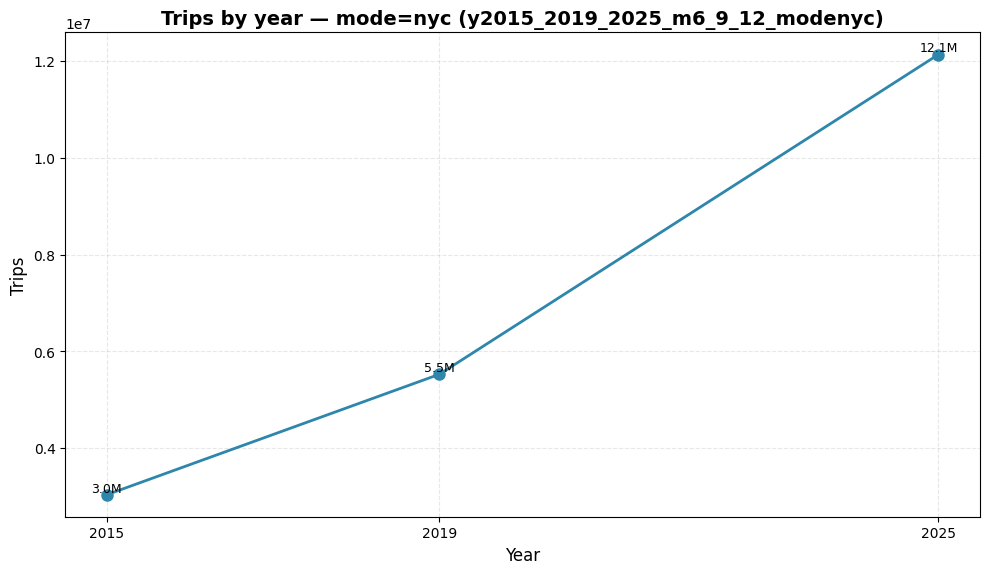

In [3]:
# --- Trips by year (THIS RUN) ---
g = df_year.copy()

if "year" in g.columns:
    # Clean and prepare data
    g["year"] = pd.to_numeric(g["year"], errors="coerce")
    g = g.dropna(subset=["year"]).sort_values("year").reset_index(drop=True)
    
display(g)

# Plot
plt.figure(figsize=(10, 6))

if "year" in g.columns and "trips" in g.columns:
    # Extract values as plain lists (no pandas magic)
    years = [int(y) for y in g["year"]]
    trips = [int(t) for t in g["trips"]]
    
    # Plot with explicit year labels
    plt.plot(years, trips, marker="o", linewidth=2, markersize=8, color='#2E86AB')
    plt.xticks(years, [str(y) for y in years])  # Explicit year labels
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add value labels on points
    for year, trip in zip(years, trips):
        plt.text(year, trip, f'{trip/1e6:.1f}M', 
                ha='center', va='bottom', fontsize=9)

plt.title(f"Trips by year — mode={mode} ({run_label})", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Trips", fontsize=12)
plt.tight_layout()

savefig("01_trips_by_year.png")
plt.show()


## 2) Month patterns (comparison)

,mode,year,month,trips
0,nyc,2015,6,941219
1,nyc,2015,9,1289699
2,nyc,2015,12,804125
3,nyc,2019,6,2125370
4,nyc,2019,9,2444900
5,nyc,2019,12,955210
6,nyc,2025,6,4758167
7,nyc,2025,9,5286096
8,nyc,2025,12,2091392


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/02_trips_by_year_month.png


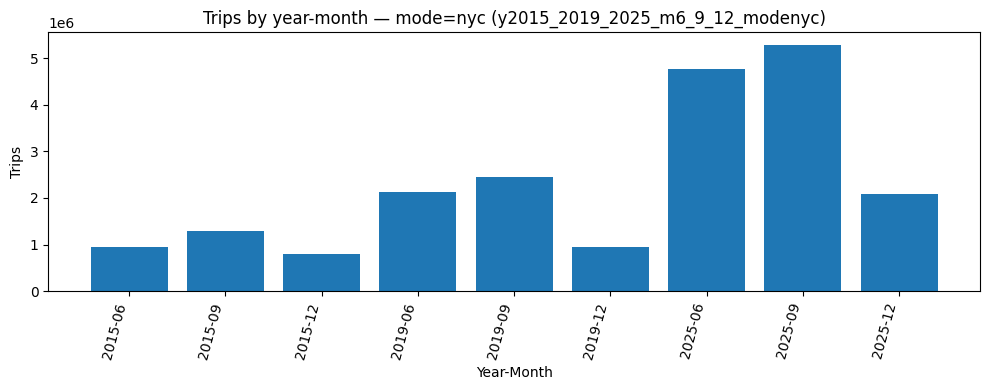

In [4]:
# --- Trips by month (THIS RUN) ---
m = df_month.copy()

# Normalize month labels
if "month" in m.columns:
    m["month"] = pd.to_numeric(m["month"], errors="coerce").astype("Int64")
if "year" in m.columns:
    m["year"] = pd.to_numeric(m["year"], errors="coerce").astype("Int64")

display(m.sort_values([c for c in ["year", "month"] if c in m.columns]))

# If multiple years, show stacked-ish bars by year-month
if {"year", "month", "trips"}.issubset(m.columns):
    m2 = m.dropna(subset=["year","month"]).copy()
    m2["ym"] = m2["year"].astype(int).astype(str) + "-" + m2["month"].astype(int).astype(str).str.zfill(2)

    plt.figure(figsize=(10,4))
    plt.bar(m2["ym"], m2["trips"])
    plt.title(f"Trips by year-month — mode={mode} ({run_label})")
    plt.xlabel("Year-Month")
    plt.ylabel("Trips")
    plt.xticks(rotation=75, ha="right")
    plt.tight_layout()
    savefig("02_trips_by_year_month.png")
    plt.show()
else:
    print("Expected columns not present for trips-by-month plot. Have:", list(m.columns))


year,2015,2019,2025
month,,,
6,941219,2125370,4758167
9,1289699,2444900,5286096
12,804125,955210,2091392


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/03_month_by_year_lines.png


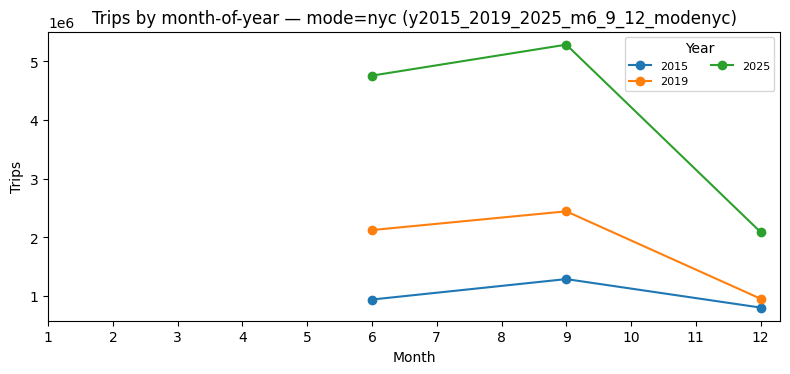

In [5]:
# --- Month-of-year seasonality (line chart per year) ---
m = df_month.copy()
if not {"year","month","trips"}.issubset(m.columns):
    print("Month table missing required columns:", list(m.columns))
else:
    m["year"]  = pd.to_numeric(m["year"], errors="coerce").astype("Int64")
    m["month"] = pd.to_numeric(m["month"], errors="coerce").astype("Int64")
    m = m.dropna(subset=["year","month"]).copy()
    m = m.sort_values(["year","month"])

    pivot = m.pivot_table(index="month", columns="year", values="trips", aggfunc="sum").sort_index()
    display(pivot)

    plt.figure(figsize=(8,4))
    for y in pivot.columns:
        plt.plot(pivot.index.astype(int), pivot[y], marker="o", label=str(int(y)))
    plt.title(f"Trips by month-of-year — mode={mode} ({run_label})")
    plt.xlabel("Month")
    plt.ylabel("Trips")
    plt.xticks(range(1,13))
    plt.legend(title="Year", ncol=2, fontsize=8)
    plt.tight_layout()
    savefig("03_month_by_year_lines.png")
    plt.show()


## 3) Day-of-week patterns (comparison)

Years present in df_dow: [2015, 2019, 2025]

Trips by day-of-week (pivot):


,year,2015,2019,2025
dow,dow_name,,,
0,Monday,438556,758483,1923801
1,Tuesday,511082,779471,1872890
2,Wednesday,511285,806968,1806064
3,Thursday,447652,755181,1749163
4,Friday,448480,785181,1782242
5,Saturday,338623,819315,1519913
6,Sunday,339365,820881,1481582



Share of trips within each year (%):


,year,2015,2019,2025
dow,dow_name,,,
0,Monday,14.45,13.73,15.85
1,Tuesday,16.84,14.11,15.43
2,Wednesday,16.85,14.60,14.88
3,Thursday,14.75,13.67,14.41
4,Friday,14.78,14.21,14.69
5,Saturday,11.16,14.83,12.52
6,Sunday,11.18,14.86,12.21


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/10_dow_year_comparison_abs.png


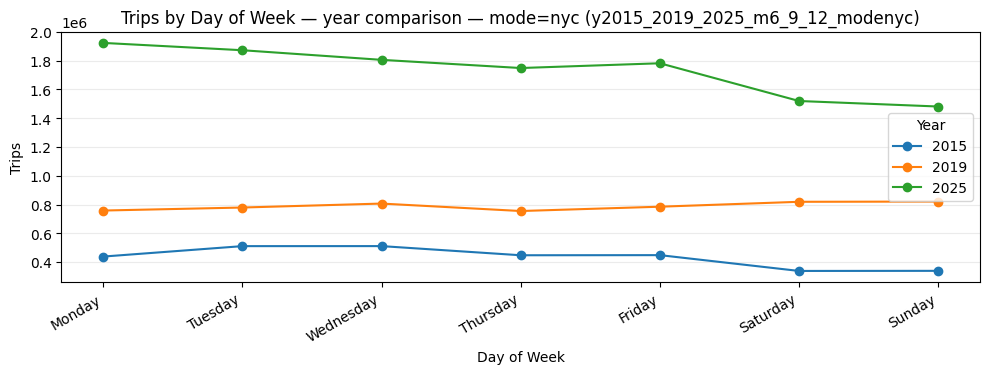

Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/10_dow_year_comparison_pct.png


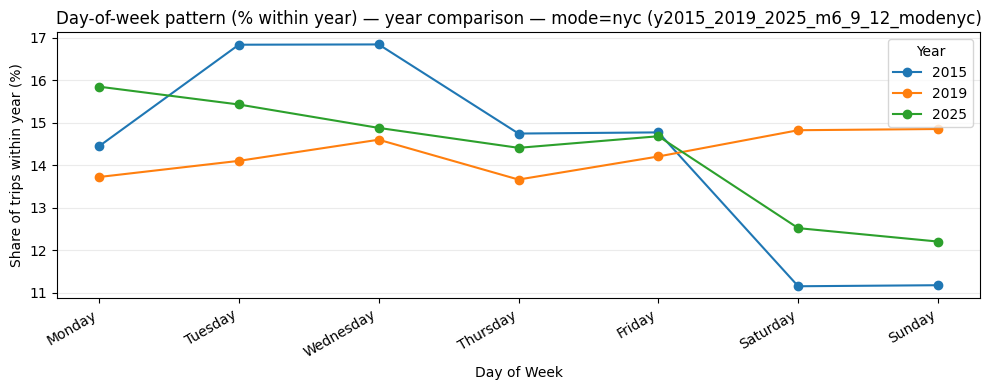

Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/10_weekday_weekend_year_comparison_pct.png


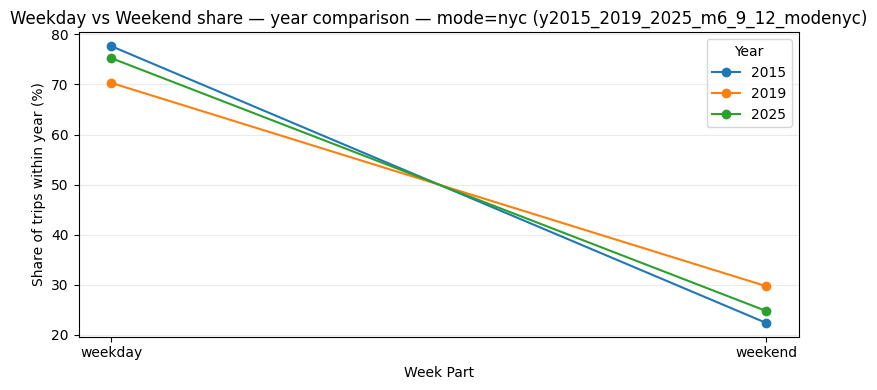

In [6]:
# --- Day-of-week patterns (comparison across years; robust even if dow_name missing) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if df_dow is None or len(df_dow) == 0:
    print("df_dow is None/empty; skipping DOW comparison.")
else:
    d = df_dow.copy()

    # ---- Required columns ----
    req = {"dow", "trips"}
    missing = [c for c in req if c not in d.columns]
    if missing:
        raise KeyError(f"df_dow missing required columns {missing}. Have: {list(d.columns)}")

    # Ensure year exists for "comparison"
    if "year" not in d.columns:
        print("df_dow has no 'year' column; cannot do year comparison.")
        display(d.head(20))
    else:
        # ---- Clean types ----
        d["dow"] = pd.to_numeric(d["dow"], errors="coerce")
        d["trips"] = pd.to_numeric(d["trips"], errors="coerce").fillna(0)
        d["year"] = pd.to_numeric(d["year"], errors="coerce")
        d = d.dropna(subset=["dow", "year"]).copy()
        d["dow"] = d["dow"].astype(int)
        d["year"] = d["year"].astype(int)

        # ---- Add dow_name if missing (deterministic mapping) ----
        if "dow_name" not in d.columns:
            dow_map = {
                0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
                4: "Friday", 5: "Saturday", 6: "Sunday",
            }
            d["dow_name"] = d["dow"].map(dow_map).fillna(d["dow"].astype(str))

        # ---- Add week_part if missing ----
        if "week_part" not in d.columns:
            d["week_part"] = np.where(d["dow"] >= 5, "weekend", "weekday")

        years = sorted(d["year"].unique().tolist())
        print("Years present in df_dow:", years)

        # ---- TABLE 1: pivot (dow_name x year) ----
        pivot = (
            d.pivot_table(index=["dow", "dow_name"], columns="year", values="trips", aggfunc="sum")
             .sort_index(level=0)
        )
        print("\nTrips by day-of-week (pivot):")
        display(pivot)

        # ---- TABLE 2: shares within each year (percent of yearly total) ----
        shares = (
            d.groupby(["year", "dow", "dow_name"], as_index=False)["trips"]
             .sum()
             .sort_values(["year", "dow"])
        )
        shares["pct_of_year"] = shares["trips"] / shares.groupby("year")["trips"].transform("sum") * 100.0
        share_pivot = (
            shares.pivot_table(index=["dow", "dow_name"], columns="year", values="pct_of_year", aggfunc="first")
                  .sort_index(level=0)
        )
        print("\nShare of trips within each year (%):")
        display(share_pivot.round(2))

        # ---- PLOT 1: absolute trips per DOW for each year ----
        plt.figure(figsize=(10, 4))
        x_labels = [f"{n}" for n in pivot.index.get_level_values("dow_name")]
        x = np.arange(len(x_labels))

        for yy in years:
            if yy in pivot.columns:
                plt.plot(x, pivot[yy].values, marker="o", label=str(yy))

        plt.xticks(x, x_labels, rotation=30, ha="right")
        plt.xlabel("Day of Week")
        plt.ylabel("Trips")
        plt.title(f"Trips by Day of Week — year comparison — mode={mode} ({run_label})")
        plt.grid(alpha=0.25, axis="y")
        plt.legend(title="Year")
        plt.tight_layout()
        savefig("10_dow_year_comparison_abs.png")
        plt.show()

        # ---- PLOT 2: % share per DOW for each year (better for pattern comparison) ----
        plt.figure(figsize=(10, 4))
        for yy in years:
            if yy in share_pivot.columns:
                plt.plot(x, share_pivot[yy].values, marker="o", label=str(yy))

        plt.xticks(x, x_labels, rotation=30, ha="right")
        plt.xlabel("Day of Week")
        plt.ylabel("Share of trips within year (%)")
        plt.title(f"Day-of-week pattern (% within year) — year comparison — mode={mode} ({run_label})")
        plt.grid(alpha=0.25, axis="y")
        plt.legend(title="Year")
        plt.tight_layout()
        savefig("10_dow_year_comparison_pct.png")
        plt.show()

        # ---- OPTIONAL: weekday vs weekend bar per year ----
        wp = (
            d.groupby(["year", "week_part"], as_index=False)["trips"]
             .sum()
             .sort_values(["year", "week_part"])
        )
        wp["pct"] = wp["trips"] / wp.groupby("year")["trips"].transform("sum") * 100.0

        plt.figure(figsize=(8, 4))
        # make consistent order
        order = ["weekday", "weekend"]
        for yy in years:
            sub = wp[wp["year"] == yy].copy()
            sub["week_part"] = pd.Categorical(sub["week_part"], categories=order, ordered=True)
            sub = sub.sort_values("week_part")
            plt.plot(sub["week_part"].astype(str), sub["pct"].values, marker="o", label=str(yy))

        plt.xlabel("Week Part")
        plt.ylabel("Share of trips within year (%)")
        plt.title(f"Weekday vs Weekend share — year comparison — mode={mode} ({run_label})")
        plt.grid(alpha=0.25, axis="y")
        plt.legend(title="Year")
        plt.tight_layout()
        savefig("10_weekday_weekend_year_comparison_pct.png")
        plt.show()


## 4) Hour-of-day patterns (comparison)

Years present in df_hour: [2015, 2019, 2025]

Sample rows per year (first 8 hours for each year):


,mode,year,hour,trips
0,nyc,2015,0,29979
1,nyc,2015,1,16642
2,nyc,2015,2,9807
3,nyc,2015,3,6062
4,nyc,2015,4,5480
5,nyc,2015,5,16208
6,nyc,2015,6,64946
7,nyc,2015,7,138501
24,nyc,2019,0,55800
25,nyc,2019,1,31806


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/05_trips_by_hour_year_comparison.png


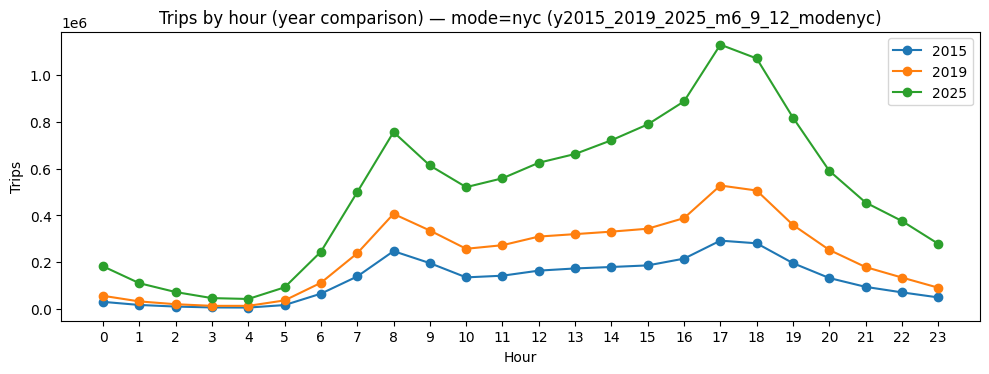

In [7]:
# --- Trips by hour: compare years (table + plot) ---

import pandas as pd
import matplotlib.pyplot as plt

h = df_hour.copy()

hour_col = "hour" if "hour" in h.columns else None
trips_col = "trips" if "trips" in h.columns else None
year_col  = "year" if "year" in h.columns else None

part_col = None
for c in ["week_part", "segment", "is_weekend"]:
    if c in h.columns:
        part_col = c
        break

if not (hour_col and trips_col and year_col):
    print("Hour table missing required columns. Have:", list(h.columns))
else:
    # Clean
    h[hour_col] = pd.to_numeric(h[hour_col], errors="coerce")
    h[trips_col] = pd.to_numeric(h[trips_col], errors="coerce")
    h[year_col] = pd.to_numeric(h[year_col], errors="coerce")
    h = h.dropna(subset=[hour_col, trips_col, year_col]).copy()
    h[hour_col] = h[hour_col].astype(int)
    h[year_col] = h[year_col].astype(int)

    years = sorted(h[year_col].unique().tolist())
    print("Years present in df_hour:", years)

    # ---- TABLES ----
    print("\nSample rows per year (first 8 hours for each year):")
    display(
        h.sort_values([year_col, hour_col])
         .groupby(year_col, as_index=False)
         .head(8)
    )

# #    if part_col:
# #        print(f"\nPivot table: trips by hour × year × {part_col}")
#         pivot = (
#             h.pivot_table(index=[hour_col, part_col], columns=year_col, values=trips_col, aggfunc="sum")
#              .sort_index()
#         )
#         display(pivot)
#     else:
#         print("\nPivot table: trips by hour × year")
#         pivot = (
#             h.pivot_table(index=hour_col, columns=year_col, values=trips_col, aggfunc="sum")
#              .sort_index()
#         )
#         display(pivot)

    # ---- PLOT ----
    plt.figure(figsize=(10,4))
    if part_col:
        for (yy, seg), sub in h.groupby([year_col, part_col]):
            sub = sub.sort_values(hour_col)
            plt.plot(sub[hour_col], sub[trips_col], marker="o", label=f"{yy} | {seg}")
    else:
        for yy, sub in h.groupby(year_col):
            sub = sub.sort_values(hour_col)
            plt.plot(sub[hour_col], sub[trips_col], marker="o", label=str(yy))

    plt.title(f"Trips by hour (year comparison) — mode={mode} ({run_label})")
    plt.xlabel("Hour")
    plt.ylabel("Trips")
    plt.xticks(range(0,24,1))
    plt.legend()
    plt.tight_layout()
    savefig("05_trips_by_hour_year_comparison.png")
    plt.show()


## 5) Station exposure (optional)

,year,month,station_id,station_name,trips
0,2015,6,521,8 Ave & W 31 St,23345
1,2015,9,521,8 Ave & W 31 St,26798
2,2015,12,519,Pershing Square North,17595
3,2019,6,519,Pershing Square North,29474
4,2019,9,519,Pershing Square North,33714
5,2019,12,519,Pershing Square North,15057
6,2025,6,5329.03,West St & Chambers St,33726
7,2025,9,6140.05,W 21 St & 6 Ave,38294
8,2025,12,6140.05,W 21 St & 6 Ave,16803


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/06_yearly_pie_top_station_exposure.png


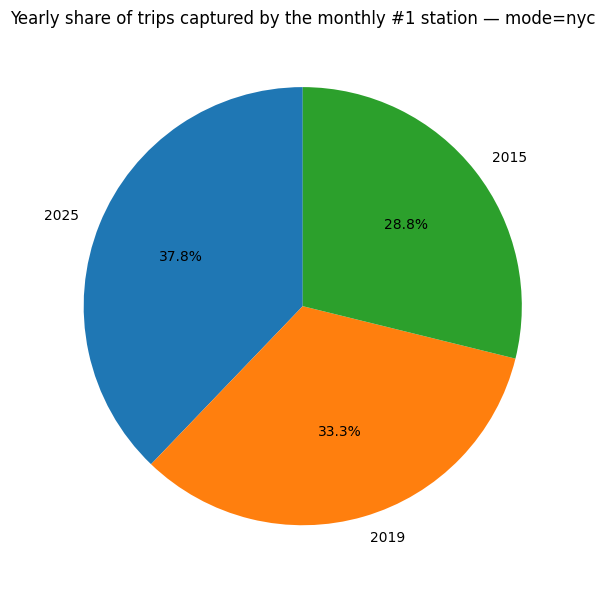

In [8]:
# --- Station exposure: top station for each year+month + yearly pie comparison ---

if df_station is None:
    print("No station exposure file found (citibike_station_exposure.csv). Skipping.")
else:
    s = df_station.copy()

    # Normalize column names across modes / scripts
    if "station_name" not in s.columns and "start_station_name" in s.columns:
        s = s.rename(columns={"start_station_name": "station_name"})
    if "station_id" not in s.columns and "start_station_id" in s.columns:
        s = s.rename(columns={"start_station_id": "station_id"})

    trips_col = "trips" if "trips" in s.columns else None
    name_col = "station_name" if "station_name" in s.columns else None

    # Validate required columns
    missing = []
    if trips_col is None:
        missing.append("trips")
    if name_col is None:
        missing.append("station_name (or start_station_name)")
    for c in ["year", "month", "station_id"]:
        if c not in s.columns:
            missing.append(c)

    if missing:
        print("Station exposure table missing required columns:", missing)
        print("Available columns:", list(s.columns))
    else:
        # Clean
        s[trips_col] = pd.to_numeric(s[trips_col], errors="coerce")
        s = s.dropna(subset=[trips_col, "year", "month", "station_id", name_col]).copy()

        # Keep station_id stable (avoid float formatting issues)
        s["station_id"] = s["station_id"].astype(str)

        # ------------------------------------------------------------
        # 1) TABLE: Top station (rank 1) for each year-month
        #    If your data has one row per station per month already,
        #    this will pick the max trips station for each year-month.
        # ------------------------------------------------------------
        ym_top = (
            s.groupby(["year", "month", "station_id", name_col], as_index=False)[trips_col]
             .sum()
             .sort_values(["year", "month", trips_col, "station_id"],
                          ascending=[True, True, False, True])   # deterministic ties
             .groupby(["year", "month"], as_index=False)
             .head(1)
             .reset_index(drop=True)
        )

        # Make it easier to read
        ym_top = ym_top.sort_values(["year", "month"]).reset_index(drop=True)

        try:
            display(ym_top)
        except NameError:
            print(ym_top.to_string(index=False))

        # Optional: also save this table as a CSV into your report outputs if you want
        # ym_top.to_csv("06_top_station_by_year_month.csv", index=False)

        # ------------------------------------------------------------
        # 2) PIE: Yearly comparison (share of trips for the *monthly top station*)
        #    This answers: "In which year is the *top-station exposure* larger/smaller?"
        # ------------------------------------------------------------
        yearly_topstation_trips = (
            ym_top.groupby("year", as_index=False)[trips_col]
                 .sum()
                 .sort_values(trips_col, ascending=False)
        )

        plt.figure(figsize=(6, 6))
        plt.pie(
            yearly_topstation_trips[trips_col].values,
            labels=yearly_topstation_trips["year"].astype(int).astype(str).values,
            autopct="%1.1f%%",
            startangle=90
        )
        plt.title(f"Yearly share of trips captured by the monthly #1 station — mode={mode}")
        plt.tight_layout()
        savefig("06_yearly_pie_top_station_exposure.png")
        plt.show()


## 6) Crash proximity / risk proxy (optional)

### 6.1 Station-level prioritization (make the proxy usable)

The raw file includes **crash counts within 250m/500m** of each station plus **trip volume**.  
To avoid misleading outliers (e.g., stations with only a handful of trips), we:

- keep IDs as **strings** (so `2231.10` doesn’t turn into `2231.1`)
- recompute crash-rates per 100k trips (defensive)
- rank **exposure** (most trips) separately from **risk rate** (filtered to stations with enough trips)

You can tune `MIN_TRIPS_FOR_RATE` depending on how conservative you want to be.


Using risk source: by_year  | columns=['mode', 'start_station_id', 'start_station_name', 'year', 'trips', 'start_trips', 'end_trips', 'touchpoints', 'station_lat', 'station_lng'] ...

=== Year 2015 — radius=500m — trips ≥ 5000 ===
Top 20 by exposure:


,mode,year,station_id,station_name,trips
467,nyc,2015,519,Pershing Square North,65271
469,nyc,2015,521,8 Ave & W 31 St,59488
96,nyc,2015,293,Lafayette St & E 8 St,56106
385,nyc,2015,435,W 21 St & 6 Ave,51723
446,nyc,2015,497,E 17 St & Broadway,51665
377,nyc,2015,426,West St & Chambers St,48444
92,nyc,2015,285,Broadway & E 14 St,44963
11,nyc,2015,151,Cleveland Pl & Spring St,42195
356,nyc,2015,402,Broadway & E 22 St,41262
91,nyc,2015,284,Greenwich Ave & 8 Ave,40725


Top 20 by EB crash-proxy:


,mode,year,station_id,station_name,trips,crashes_within_500m,eb_rate_per_100k_trips
209,nyc,2015,3134,3 Ave & E 62 St,6198,455,2655.967618
269,nyc,2015,3223,E 55 St & 3 Ave,8068,494,2617.964930
38,nyc,2015,2023,E 55 St & Lexington Ave,9148,484,2486.655676
278,nyc,2015,3234,E 40 St & Madison Ave,5381,384,2461.724899
15,nyc,2015,160,E 37 St & Lexington Ave,11716,509,2364.139225
207,nyc,2015,3132,E 59 St & Madison Ave,6449,374,2324.512823
94,nyc,2015,290,2 Ave & E 58 St,10312,446,2265.803631
277,nyc,2015,3233,E 48 St & 5 Ave,5596,321,2194.914817
326,nyc,2015,367,E 53 St & Lexington Ave,11222,435,2164.532690
218,nyc,2015,3142,1 Ave & E 62 St,9603,385,2114.010055



=== Year 2019 — radius=500m — trips ≥ 5000 ===
Top 20 by exposure:


,mode,year,station_id,station_name,trips
1391,nyc,2019,519,Pershing Square North,78245
1315,nyc,2019,426,West St & Chambers St,64702
1374,nyc,2019,497,E 17 St & Broadway,64204
568,nyc,2019,285,Broadway & E 14 St,63183
737,nyc,2019,3255,8 Ave & W 31 St,62802
1297,nyc,2019,402,Broadway & E 22 St,61844
1386,nyc,2019,514,12 Ave & W 40 St,59998
1016,nyc,2019,358,Christopher St & Greenwich St,57136
1375,nyc,2019,499,Broadway & W 60 St,56597
1338,nyc,2019,459,W 20 St & 11 Ave,51477


Top 20 by EB crash-proxy:


,mode,year,station_id,station_name,trips,crashes_within_500m,eb_rate_per_100k_trips
730,nyc,2019,3243,E 58 St & 1 Ave (NE Corner),6974,317,1738.646129
688,nyc,2019,3155,Lexington Ave & E 63 St,5654,281,1687.777371
523,nyc,2019,2023,E 55 St & Lexington Ave,7845,307,1648.347663
1395,nyc,2019,524,W 43 St & 6 Ave,5337,262,1633.904593
1342,nyc,2019,464,E 56 St & 3 Ave,9125,306,1572.471783
562,nyc,2019,278,Concord St & Bridge St,5724,228,1477.151324
1127,nyc,2019,3734,E 58 St & 1 Ave (NW Corner),12611,316,1435.044637
908,nyc,2019,3457,E 58 St & Madison Ave,10574,280,1412.907721
522,nyc,2019,2022,E 60 St & York Ave,6672,223,1405.902845
668,nyc,2019,3134,3 Ave & E 62 St,14114,313,1363.025171



=== Year 2025 — radius=500m — trips ≥ 5000 ===
Top 20 by exposure:


,mode,year,station_id,station_name,trips
2589,nyc,2025,6140.05,W 21 St & 6 Ave,88015
2646,nyc,2025,6233.04,Pier 61 at Chelsea Piers,78567
2260,nyc,2025,5329.03,West St & Chambers St,78237
2450,nyc,2025,5788.13,Lafayette St & E 8 St,76316
2922,nyc,2025,6726.01,11 Ave & W 41 St,71340
2708,nyc,2025,6331.01,W 31 St & 7 Ave,71174
2483,nyc,2025,5905.12,Broadway & E 14 St,71091
2790,nyc,2025,6492.08,9 Ave & W 33 St,70952
2484,nyc,2025,5905.14,University Pl & E 14 St,68356
2774,nyc,2025,6459.07,W 30 St & 10 Ave,64343


Top 20 by EB crash-proxy:


,mode,year,station_id,station_name,trips,crashes_within_500m,eb_rate_per_100k_trips
3197,nyc,2025,7563.06,E 116 St & 2 Ave,5525,88,529.566667
2267,nyc,2025,5343.1,Allen St & Hester St,7421,97,525.771824
2835,nyc,2025,6569.08,W 35 St & Dyer Ave,5852,86,515.131873
2036,nyc,2025,4781.03,Concord St & Bridge St,9319,103,512.199911
3232,nyc,2025,7652.04,Lexington Ave & E 120 St,5751,83,505.502279
3211,nyc,2025,7611.02,E 118 St & 3 Ave,7541,92,505.326211
3339,nyc,2025,7893.05,Adam Clayton Powell Blvd & W 141 St,5562,78,489.679571
3183,nyc,2025,7504.19,3 Ave & E 109 St,6175,80,485.852500
3237,nyc,2025,7662.13,Lexington Ave & E 127 St,5006,73,480.572230
2059,nyc,2025,4826.04,Wallabout St & Kent Ave,5645,75,476.396537


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/09_yearly_EB_crash_proxy_burden_500m.png


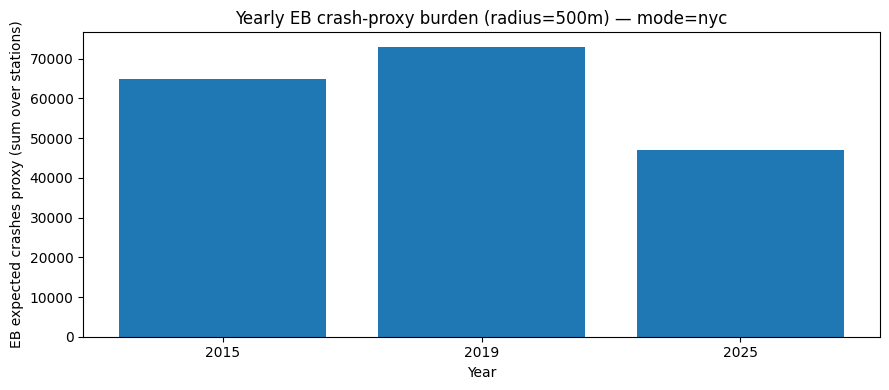

In [9]:
# --- Crash proximity risk proxy (NYC only): YEARLY comparison + radius-aware ---

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MIN_TRIPS_FOR_RATE = 5000
TOP_N = 20
EB_M_PRIOR = 20000.0
SCALE = 100000.0

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        raise ValueError(f"Bad AXA_RADIUS={raw!r}. Use like 450m, 750, 1km, auto.")
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    if meters <= 0:
        raise ValueError(f"AXA_RADIUS must be > 0 (got {raw!r})")
    return int(round(meters))

def available_radii(df: pd.DataFrame) -> list[int]:
    radii = []
    for c in df.columns:
        mm = re.match(r"^crashes_within_(\d+)m$", str(c))
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def ensure_int_col(df: pd.DataFrame, col: str) -> None:
    if col not in df.columns:
        df[col] = 0
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

def eb_rate_per_trip(k: np.ndarray, e: np.ndarray, m_prior: float) -> np.ndarray:
    k = k.astype(float)
    e = e.astype(float)
    e_sum = float(np.nansum(e))
    r0 = float(np.nansum(k) / e_sum) if e_sum > 0 else 0.0
    return (k + r0 * m_prior) / (e + m_prior)

# Prefer by-year if available; else fall back to overall
r = None
source = None
if "df_risk_year" in globals() and df_risk_year is not None:
    r = df_risk_year.copy()
    source = "by_year"
elif "df_risk_ym" in globals() and df_risk_ym is not None:
    # you can still aggregate to year in this cell
    r = df_risk_ym.copy()
    source = "by_year_month"
elif "df_risk_overall" in globals() and df_risk_overall is not None:
    r = df_risk_overall.copy()
    source = "overall"
elif "df_risk" in globals() and df_risk is not None:
    r = df_risk.copy()
    source = "unknown_df_risk"

if r is None:
    print("No station risk file found. Skipping crash-proxy section.")
else:
    print(f"Using risk source: {source}  | columns={list(r.columns)[:10]} ...")

    # Normalize ids/names
    if "station_id" not in r.columns and "start_station_id" in r.columns:
        r = r.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in r.columns and "start_station_name" in r.columns:
        r = r.rename(columns={"start_station_name": "station_name"})

    # If we only have overall, we cannot do year comparisons
    if "year" not in r.columns:
        print("This risk table has no 'year' column (overall aggregate).")
        print("To enable yearly comparison you must generate:")
        print("  - station_risk_exposure_plus_crashproximity_by_year.csv")
        print("or - station_risk_exposure_plus_crashproximity_by_year_month.csv")
    else:
        # Clean types
        r["year"] = pd.to_numeric(r["year"], errors="coerce")
        r["trips"] = pd.to_numeric(r.get("trips", pd.NA), errors="coerce")
        r = r.dropna(subset=["year", "trips"]).copy()
        r = r[r["trips"] > 0].copy()
        r["station_id"] = r["station_id"].astype(str)

        # Choose radius
        avail = available_radii(r)
        if not avail:
            print("No crashes_within_<R>m columns found. Skipping.")
        else:
            env_raw = os.environ.get("AXA_RADIUS", "auto")
            wanted_m = parse_radius_to_m(env_raw)
            chosen_m = max(avail) if wanted_m == -1 else wanted_m
            if chosen_m not in avail:
                fallback = 500 if 500 in avail else max(avail)
                print(f"Requested {chosen_m}m not available; falling back to {fallback}m. Available={avail}")
                chosen_m = fallback

            crash_col = f"crashes_within_{chosen_m}m"
            ensure_int_col(r, crash_col)

            # If source is by_year_month, aggregate to year for “yearly comparison”
            if "month" in r.columns:
                r["month"] = pd.to_numeric(r["month"], errors="coerce")
                # Aggregate to year: sum crashes/trips, keep representative name
                r = (
                    r.groupby(["mode","year","station_id","station_name"], as_index=False)
                     .agg(
                        trips=("trips","sum"),
                        **{crash_col: (crash_col,"sum")},
                     )
                )

            years = sorted(int(y) for y in r["year"].dropna().unique().tolist())
            if not years:
                print("No valid years found in risk table after cleaning.")
            else:
                yearly_burden = []

                for yy in years:
                    ry = r[r["year"] == yy].copy()
                    stable = ry[ry["trips"] >= MIN_TRIPS_FOR_RATE].copy()
                    if stable.empty:
                        print(f"Year {yy}: no stations with trips >= {MIN_TRIPS_FOR_RATE}.")
                        continue

                    stable["eb_rate_per_100k_trips"] = eb_rate_per_trip(
                        stable[crash_col].to_numpy(),
                        stable["trips"].to_numpy(),
                        EB_M_PRIOR,
                    ) * SCALE

                    # “Burden” = expected crashes proxy = rate * exposure
                    stable["_eb_expected_crashes"] = (stable["eb_rate_per_100k_trips"] / SCALE) * stable["trips"]

                    print(f"\n=== Year {yy} — radius={chosen_m}m — trips ≥ {MIN_TRIPS_FOR_RATE} ===")
                    print(f"Top {TOP_N} by exposure:")
                    display(stable.sort_values("trips", ascending=False).head(TOP_N)[
                        ["mode","year","station_id","station_name","trips"]
                    ])

                    print(f"Top {TOP_N} by EB crash-proxy:")
                    display(stable.sort_values("eb_rate_per_100k_trips", ascending=False).head(TOP_N)[
                        ["mode","year","station_id","station_name","trips",crash_col,"eb_rate_per_100k_trips"]
                    ])

                    yearly_burden.append({"year": yy, "eb_expected_crashes": stable["_eb_expected_crashes"].sum()})

                if yearly_burden:
                    yb = pd.DataFrame(yearly_burden).sort_values("year")

                    plt.figure(figsize=(9,4))
                    plt.bar(yb["year"].astype(str), yb["eb_expected_crashes"].values)
                    plt.title(f"Yearly EB crash-proxy burden (radius={chosen_m}m) — mode={mode}")
                    plt.xlabel("Year")
                    plt.ylabel("EB expected crashes proxy (sum over stations)")
                    plt.tight_layout()
                    savefig(f"09_yearly_EB_crash_proxy_burden_{chosen_m}m.png")
                    plt.show()
                else:
                    print("No yearly burden values computed (maybe MIN_TRIPS_FOR_RATE too high).")


### 6.2 Alternative Risk Metrics (Intuitive Formats)

The standard `per_100k_trips` metric is useful for technical analysis, but can be hard to interpret.
This section adds alternative formats that are more intuitive for different audiences:

- **Percentage** (crash_rate_pct): Good for executives
- **Trips per crash**: Most intuitive for general public
- **Risk level**: Classification (Very Low → Very High)
- **Risk score**: 0-100 ranking score

,stations
zone,
High exposure / Lower risk,690
Lower exposure / High risk,690
High exposure / High risk,319
Lower exposure / Lower risk,319


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2015_2019_2025_m6_9_12_modenyc/figures/10_zones_exposure_vs_risk_500m_trips_ge_5000.png


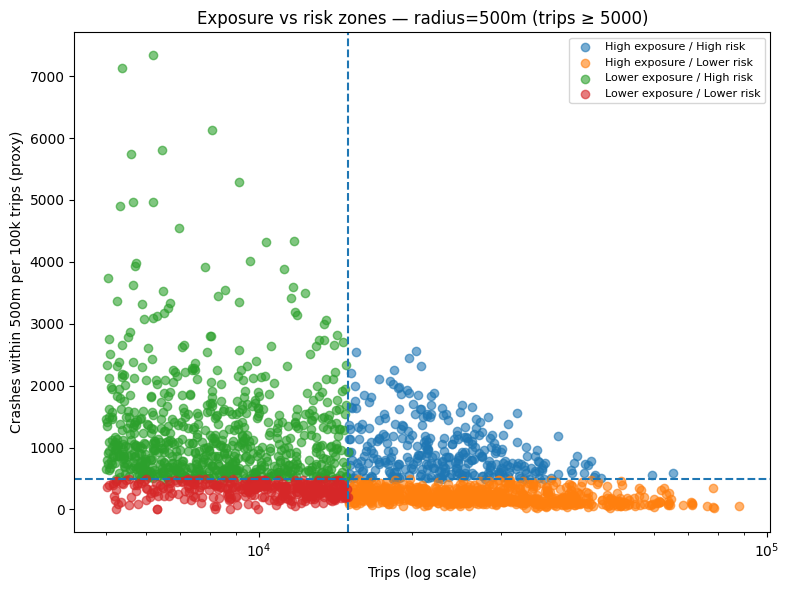

High exposure + high proxy risk (top 15):


,mode,station_id,station_name,trips,crashes_within_500m,crashes_per_100k_trips
118,nyc,305,E 58 St & 3 Ave,20343,522,2565.993216
481,nyc,533,Broadway & W 39 St,15535,395,2542.645639
35,nyc,2021,W 45 St & 8 Ave,19708,483,2450.781409
18,nyc,167,E 39 St & 3 Ave,20830,484,2323.571771
449,nyc,500,Broadway & W 51 St,18447,415,2249.688296
390,nyc,440,E 45 St & 3 Ave,15158,335,2210.054097
77,nyc,265,Stanton St & Chrystie St,17254,364,2109.655732
434,nyc,485,W 37 St & 5 Ave,18075,376,2080.221300
80,nyc,268,Howard St & Centre St,18330,371,2024.004364
1135,nyc,3749,Lexington Ave & E 36 St,15446,309,2000.517933


In [10]:
# --- Exposure vs Risk "Zones" (simple quadrant view, radius-aware) ---
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MIN_TRIPS_FOR_ZONES = 5000
SCALE = 100000.0

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        return -1
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    return int(round(meters)) if meters > 0 else -1

def available_radii(df: pd.DataFrame) -> list[int]:
    radii = []
    for c in df.columns:
        mm = re.match(r"^crashes_within_(\d+)m$", str(c))
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def ensure_int_col(df: pd.DataFrame, col: str) -> None:
    if col not in df.columns:
        df[col] = 0
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

if df_risk is None:
    print("No station risk file found. Skipping zones plot.")
else:
    r = df_risk.copy()
    if "station_id" not in r.columns and "start_station_id" in r.columns:
        r = r.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in r.columns and "start_station_name" in r.columns:
        r = r.rename(columns={"start_station_name": "station_name"})

    r["trips"] = pd.to_numeric(r.get("trips", pd.NA), errors="coerce")
    r = r.dropna(subset=["trips"]).copy()
    r = r[r["trips"] > 0].copy()

    avail = available_radii(r)
    if not avail:
        print("No crashes_within_<R>m columns found. Skipping zones plot.")
    else:
        env_raw = os.environ.get("AXA_RADIUS", "auto")
        wanted = parse_radius_to_m(env_raw)
        chosen = max(avail) if wanted == -1 else (wanted if wanted in avail else (500 if 500 in avail else max(avail)))

        crash_col = f"crashes_within_{chosen}m"
        ensure_int_col(r, crash_col)

        r = r[(r["trips"] >= MIN_TRIPS_FOR_ZONES)].copy()
        if len(r) == 0:
            print("No stations meet trips ≥", MIN_TRIPS_FOR_ZONES, "— skipping zones plot.")
        else:
            r["crashes_per_100k_trips"] = (r[crash_col] / r["trips"].replace({0: np.nan})) * SCALE
            r["crashes_per_100k_trips"] = pd.to_numeric(r["crashes_per_100k_trips"], errors="coerce").fillna(0.0)

            x = r["trips"].astype(float)
            y = r["crashes_per_100k_trips"].astype(float)

            x_med = float(np.nanmedian(x))
            y_med = float(np.nanmedian(y))
            
            def zone(row):
                hi_x = float(row["trips"]) >= x_med
                # FIX 1: use the radius-aware metric you computed
                hi_y = float(row["crashes_per_100k_trips"]) >= y_med
                if hi_x and hi_y:
                    return "High exposure / High risk"
                if hi_x and (not hi_y):
                    return "High exposure / Lower risk"
                if (not hi_x) and hi_y:
                    return "Lower exposure / High risk"
                return "Lower exposure / Lower risk"
            
            r["zone"] = r.apply(zone, axis=1)
            display(r["zone"].value_counts().to_frame("stations"))

            # Plot quadrants
            plt.figure(figsize=(8, 6))
            for z, sub in r.groupby("zone"):
                # FIX 2: plot the column that exists
                plt.scatter(sub["trips"], sub["crashes_per_100k_trips"], alpha=0.6, label=z)

            plt.axvline(x_med, linestyle="--")
            plt.axhline(y_med, linestyle="--")
            plt.xscale("log")
            plt.xlabel("Trips (log scale)")
            plt.ylabel(f"Crashes within {chosen}m per 100k trips (proxy)")
            plt.title(f"Exposure vs risk zones — radius={chosen}m (trips ≥ {MIN_TRIPS_FOR_ZONES})")
            plt.legend(fontsize=8)
            plt.tight_layout()
            savefig(f"10_zones_exposure_vs_risk_{chosen}m_trips_ge_{MIN_TRIPS_FOR_ZONES}.png")
            plt.show()
            # FIX 3: use plt.savefig
            #plt.savefig(f"10_zones_exposure_vs_risk_{chosen}m_trips_ge_{MIN_TRIPS_FOR_ZONES}.png", dpi=200)
            #plt.show()

            # Small table of "high-high" quadrant
            hh = r[(x >= x_med) & (y >= y_med)].copy()
            hh = hh.sort_values(["crashes_per_100k_trips", "trips"], ascending=False).head(15)
            print("High exposure + high proxy risk (top 15):")
            display(hh[["mode","station_id","station_name","trips", crash_col, "crashes_per_100k_trips"]])
            
            
            #crash_col = "crashes_within_900m"  # or your chosen crash_col variable
            #print("non-zero stations:", (df_risk[crash_col] > 0).sum())
            #print("total crashes counted:", int(df_risk[crash_col].sum()))
            tmp = df_risk.copy()

 
            
            


            



## 7) AXA Partner Decision Assets: Where + When + What

This section turns your outputs into **two decision assets**:

- **WHERE to focus** (stations): `axa_partner_scorecard_500m.csv`
- **WHEN to activate** (time windows): `axa_target_windows.csv`

Both files are produced by the Make targets you already ran.


In [11]:
# --- Load AXA assets for THIS run_dir (radius-aware, no global fallback) ---
from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        raise ValueError(f"Bad AXA_RADIUS={raw!r}. Use like 450m, 750, 1km, auto.")
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    if meters <= 0:
        raise ValueError(f"AXA_RADIUS must be > 0 (got {raw!r})")
    return int(round(meters))

def available_scorecards(run_dir: Path) -> list[int]:
    radii = []
    for p in run_dir.glob("axa_partner_scorecard_*m.csv"):
        mm = re.match(r"^axa_partner_scorecard_(\d+)m\.csv$", p.name)
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def scorecard_path_for_radius(run_dir: Path, radius_env: str) -> Path | None:
    avail = available_scorecards(run_dir)
    if not avail:
        return None
    wanted = parse_radius_to_m(radius_env)
    if wanted == -1:
        chosen = max(avail)
    else:
        chosen = wanted if wanted in avail else (500 if 500 in avail else max(avail))
    p = run_dir / f"axa_partner_scorecard_{chosen}m.csv"
    return p if p.exists() else None

radius_env = os.environ.get("AXA_RADIUS", "auto")
scorecard_path = scorecard_path_for_radius(RUN_DIR, radius_env)

windows_path = RUN_DIR / "axa_target_windows.csv"

df_score = pd.read_csv(scorecard_path) if scorecard_path and scorecard_path.exists() else None
df_windows = pd.read_csv(windows_path) if windows_path.exists() else None

print("AXA_RADIUS (env):", radius_env)
print("Scorecard path:", scorecard_path if scorecard_path else "NOT FOUND")
print("Windows path:", windows_path if windows_path.exists() else "NOT FOUND")

print("df_score is None?", df_score is None)
print("df_windows is None?", df_windows is None)
print("CWD:", os.getcwd())

if df_score is not None:
    display(df_score.head(10))
if df_windows is not None:
    display(df_windows.head(10))


AXA_RADIUS (env): 500m
Scorecard path: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2015_2019_2025_m6_9_12_modenyc/axa_partner_scorecard_500m.csv
Windows path: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2015_2019_2025_m6_9_12_modenyc/axa_target_windows.csv
df_score is None? False
df_windows is None? False
CWD: /home/maral/Desktop/citibike-insurance-challenge/notebooks


,mode,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,...,risk_pct,axa_priority_score,prevention_hotspot,product_hotspot,acquisition_hotspot,exposure_index_pct,eb_risk_rate_per_100k_trips,risk_index_pct,expected_incidents_proxy,scoring_strategy
0,nyc,529,W 42 St & 8 Ave,40.757570,-73.990985,58948,1020,1730.338604,1625.765487,1839.873469,...,0.486502,1.000000,False,True,False,97.777778,1738.651819,48.650169,1024.900475,eb_expected_incidents_mintrips5000_mprior1000
1,nyc,6602.05,W 42 St & 8 Ave,40.757570,-73.990985,32690,1020,3120.220251,2931.649555,3317.738184,...,0.785152,0.999700,False,True,False,89.339339,3093.757770,78.515186,1011.349415,eb_expected_incidents_mintrips5000_mprior1000
2,nyc,305,E 58 St & 3 Ave,40.760958,-73.967245,45795,958,2091.931434,1961.543103,2228.708715,...,0.571991,0.999399,False,True,False,95.135135,2094.854135,57.199100,959.338451,eb_expected_incidents_mintrips5000_mprior1000
3,nyc,6762.02,E 58 St & 3 Ave,40.760958,-73.967245,36911,958,2595.432256,2433.661142,2765.130059,...,0.685602,0.999099,False,True,False,91.771772,2585.758731,68.560180,954.429405,eb_expected_incidents_mintrips5000_mprior1000
4,nyc,2021,W 45 St & 8 Ave,40.759291,-73.988597,47229,944,1998.771941,1873.284635,2130.454703,...,0.548931,0.998799,False,True,False,95.255255,2003.539349,54.893138,946.251599,eb_expected_incidents_mintrips5000_mprior1000
5,nyc,477,W 41 St & 8 Ave,40.756405,-73.990026,83846,934,1113.946998,1043.643627,1187.740363,...,0.248031,0.998498,False,True,True,99.549550,1127.085535,24.803150,945.016137,eb_expected_incidents_mintrips5000_mprior1000
6,nyc,6676.02,W 45 St & 8 Ave,40.759291,-73.988597,42331,944,2230.044176,2090.037090,2376.963576,...,0.607424,0.998198,False,True,False,94.054054,2230.013138,60.742407,943.986861,eb_expected_incidents_mintrips5000_mprior1000
7,nyc,6602.03,W 41 St & 8 Ave,40.756405,-73.990026,56006,934,1667.678463,1562.428018,1778.153742,...,0.462880,0.997898,False,True,False,97.327327,1677.519897,46.287964,939.511794,eb_expected_incidents_mintrips5000_mprior1000
8,nyc,6644.07,W 42 St & Dyer Ave,40.758985,-73.993800,24890,947,3804.740860,3566.243393,4054.994059,...,0.876265,0.997598,True,True,False,83.453453,3743.866329,87.626547,931.848329,eb_expected_incidents_mintrips5000_mprior1000
9,nyc,3236,W 42 St & Dyer Ave,40.758985,-73.993800,21802,947,4343.638198,4071.360336,4629.336855,...,0.916760,0.997297,True,True,False,80.240240,4250.885855,91.676040,926.778134,eb_expected_incidents_mintrips5000_mprior1000


,window_type,segment,window_label,trips,pct_of_mode_year_trips,pct_within_week_part,priority_metric,recommended_action


In [12]:
# --- EB-enrich the AXA scorecard (so priority behaves like an insurer) ---
# We compute a credibility-smoothed (Empirical Bayes) risk rate and an insurer-ish priority:
#   expected_incidents_proxy = EB_rate_per_trip * exposure_trips
# This avoids tiny-station outliers and produces a "risk × exposure" ranking.

import numpy as np
import pandas as pd

MIN_TRIPS_FOR_SIGNAL = 5000
EB_M_PRIOR = 20000.0
SCALE = 100000.0

if df_score is None:
    print("No scorecard loaded (df_score is None). Skipping EB enrichment.")
else:
    s = df_score.copy()

    # Normalize column names
    if "station_id" not in s.columns and "start_station_id" in s.columns:
        s = s.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in s.columns and "start_station_name" in s.columns:
        s = s.rename(columns={"start_station_name": "station_name"})
    if "exposure_trips" not in s.columns and "trips" in s.columns:
        s = s.rename(columns={"trips": "exposure_trips"})

    # Ensure mode exists
    if "mode" not in s.columns:
        s["mode"] = mode

    # Ensure numerics
    for c in ["exposure_trips", "crash_count", "risk_rate_per_100k_trips"]:
        if c in s.columns:
            s[c] = pd.to_numeric(s[c], errors="coerce")

    # If crash_count missing, we cannot do EB
    if "crash_count" not in s.columns:
        print("Scorecard missing crash_count; EB enrichment skipped.")
    else:
        def eb_per_trip(k: pd.Series, e: pd.Series, m_prior: float) -> pd.Series:
            e_sum = float(e.sum())
            r0 = float(k.sum() / e_sum) if e_sum > 0 else 0.0
            return (k + r0 * m_prior) / (e + m_prior)

        out_parts = []
        for m, g in s.groupby("mode", dropna=False):
            g = g.copy()

            g["exposure_trips"] = g["exposure_trips"].fillna(0).astype(float)
            g["crash_count"] = g["crash_count"].fillna(0).astype(float)

            stable = g["exposure_trips"] >= float(MIN_TRIPS_FOR_SIGNAL)

            # Determine if proxy has usable signal in this mode
            if "risk_rate_per_100k_trips" in g.columns and g["risk_rate_per_100k_trips"].notna().any():
                risk_has_signal = (g.loc[stable, "risk_rate_per_100k_trips"].nunique(dropna=True) > 1) if stable.any() else False
            else:
                risk_has_signal = (g.loc[stable, "crash_count"].nunique(dropna=True) > 1) if stable.any() else False

            g["risk_proxy_available"] = bool(risk_has_signal)

            # Exposure percentile (always)
            g["exposure_index_pct"] = g["exposure_trips"].rank(pct=True, method="average") * 100.0 if g["exposure_trips"].nunique() > 1 else 50.0

            if not risk_has_signal:
                # JC-style: exposure only
                g["eb_risk_rate_per_100k"] = np.nan
                g["expected_incidents_proxy"] = np.nan
                g["eb_priority_score"] = g["exposure_index_pct"]  # 0..100
                g["scoring_strategy"] = "exposure_only_no_risk_signal"
                out_parts.append(g)
                continue

            # EB rate and expected incidents proxy
            eb_rate = eb_per_trip(g["crash_count"], g["exposure_trips"], float(EB_M_PRIOR))
            g["eb_risk_rate_per_100k"] = eb_rate * SCALE
            g["expected_incidents_proxy"] = eb_rate * g["exposure_trips"]

            # Priority = percentile of expected incidents (0..100)
            g["eb_priority_score"] = g["expected_incidents_proxy"].rank(pct=True, method="average") * 100.0 if g["expected_incidents_proxy"].nunique() > 1 else 50.0
            g["scoring_strategy"] = f"eb_expected_incidents_mprior{int(EB_M_PRIOR)}"

            out_parts.append(g)

        s2 = pd.concat(out_parts, ignore_index=True)

        # Simple action tags
        s2["eb_prevention_hotspot"] = (s2["exposure_index_pct"] >= 80.0) & (s2["eb_priority_score"] >= 80.0)
        s2["eb_product_hotspot"] = (s2["exposure_index_pct"] >= 80.0)
        s2["eb_acquisition_hotspot"] = (s2["exposure_index_pct"] >= 70.0) & (s2.get("eb_risk_rate_per_100k").fillna(0) <= s2.get("eb_risk_rate_per_100k").median())

        df_score = s2  # overwrite for downstream cells

        print("EB enrichment complete. Proxy available share by mode:")
        display(df_score.groupby("mode")["risk_proxy_available"].mean().to_frame("proxy_available_share"))

        display(
            df_score.sort_values("eb_priority_score", ascending=False)
                    .head(15)[[
                        "mode","station_id","station_name",
                        "exposure_trips","crash_count","risk_proxy_available",
                        "eb_risk_rate_per_100k","expected_incidents_proxy","eb_priority_score",
                        "scoring_strategy"
                    ]]
        )

        out_path = RUN_DIR / "axa_partner_scorecard_500m_with_eb.csv"
        df_score.to_csv(out_path, index=False)
        print("Wrote:", out_path)
        




EB enrichment complete. Proxy available share by mode:


,proxy_available_share
mode,
nyc,1.0


,mode,station_id,station_name,exposure_trips,crash_count,risk_proxy_available,eb_risk_rate_per_100k,expected_incidents_proxy,eb_priority_score,scoring_strategy
5,nyc,477,W 41 St & 8 Ave,83846.0,934.0,True,1328.640346,1114.011785,100.00000,eb_expected_incidents_mprior20000
0,nyc,529,W 42 St & 8 Ave,58948.0,1020.0,True,1856.588962,1094.422061,99.96997,eb_expected_incidents_mprior20000
77,nyc,519,Pershing Square North,143516.0,725.0,True,715.978775,1027.544099,99.93994,eb_expected_incidents_mprior20000
15,nyc,523,W 38 St & 8 Ave,74686.0,852.0,True,1370.572053,1023.625443,99.90991,eb_expected_incidents_mprior20000
7,nyc,6602.03,W 41 St & 8 Ave,56006.0,934.0,True,1815.303863,1016.679081,99.87988,eb_expected_incidents_mprior20000
11,nyc,479,9 Ave & W 45 St,58688.0,865.0,True,1665.743003,977.591253,99.84985,eb_expected_incidents_mprior20000
2,nyc,305,E 58 St & 3 Ave,45795.0,958.0,True,2133.505363,977.038781,99.81982,eb_expected_incidents_mprior20000
4,nyc,2021,W 45 St & 8 Ave,47229.0,944.0,True,2067.173175,976.305219,99.78979,eb_expected_incidents_mprior20000
27,nyc,465,Broadway & W 41 St,63502.0,814.0,True,1508.634349,958.012984,99.75976,eb_expected_incidents_mprior20000
81,nyc,151,Cleveland Pl & Spring St,88098.0,725.0,True,1083.035629,954.132728,99.72973,eb_expected_incidents_mprior20000


Wrote: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2015_2019_2025_m6_9_12_modenyc/axa_partner_scorecard_500m_with_eb.csv


In [13]:
# WHERE + WHEN + WHAT (turn the outputs into decision-ready assets)
import numpy as np
import pandas as pd

if df_score is None or df_windows is None:
    print("AXA assets not available for this run; skipping WHERE/WHEN/WHAT tables.")
else:
    score = df_score.copy()

    # Normalize station columns
    if "station_id" not in score.columns and "start_station_id" in score.columns:
        score = score.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in score.columns and "start_station_name" in score.columns:
        score = score.rename(columns={"start_station_name": "station_name"})

    # Priority preference: EB first (works for NYC; for JC it becomes exposure-only)
    if "eb_priority_score" in score.columns:
        pri_col = "eb_priority_score"
    elif "axa_priority_score" in score.columns:
        pri_col = "axa_priority_score"
    elif "exposure_trips" in score.columns:
        pri_col = "exposure_trips"
    else:
        pri_col = None

    # Columns to display (de-duplicated)
    cols = [
        "mode","station_id","station_name",
        "exposure_trips","crash_count","risk_proxy_available",
        "risk_rate_per_100k_trips","risk_rate_ci_low","risk_rate_ci_high",
        "eb_risk_rate_per_100k","expected_incidents_proxy","eb_priority_score",
        "scoring_strategy",
        "eb_prevention_hotspot","eb_product_hotspot","eb_acquisition_hotspot",
    ]
    cols = [c for c in cols if c in score.columns]
    cols = list(dict.fromkeys(cols))

    # WHERE
    if pri_col is None:
        print("No usable priority column found; showing first 20 rows of scorecard.")
        where_top = score.head(20)
    else:
        # Prefer proxy-covered first (NYC), then rank
        if "risk_proxy_available" in score.columns:
            where_top = score.sort_values(["risk_proxy_available", pri_col], ascending=[False, False]).head(20)
        else:
            where_top = score.sort_values(pri_col, ascending=False).head(20)

    print(f"WHERE to focus — top 20 stations by `{pri_col}`")
    display(where_top[cols] if cols else where_top)

    # WHEN
    w = df_windows.copy()
    for c in ["trips", "index", "lift_pct", "lift_vs_baseline_pct"]:
        if c in w.columns:
            w[c] = pd.to_numeric(w[c], errors="coerce")

    if "lift_vs_baseline_pct" in w.columns:
        w_rank = "lift_vs_baseline_pct"
    elif "lift_pct" in w.columns:
        w_rank = "lift_pct"
    elif "index" in w.columns:
        w_rank = "index"
    elif "trips" in w.columns:
        w_rank = "trips"
    else:
        w_rank = None

    when_top = w.sort_values(w_rank, ascending=False).head(20) if w_rank else w.head(20)
    print(f"WHEN to activate — top 20 windows by `{w_rank}`")
    display(when_top)

    # WHAT (brief, interview-ready)
    print("\nWHAT to propose (one-slide plan):")
    print("- NYC: use EB hotspots for prevention pilots + risk-tiered messaging/offer placement.")
    print("- JC: exposure-led rollout now; Phase 2 = add JC-local crash proxy for real risk tiering.")
    print("- Measure: attach rate, conversion uplift in target windows, and (later) claims frequency once product exists.")


WHERE to focus — top 20 stations by `eb_priority_score`


,mode,station_id,station_name,exposure_trips,crash_count,risk_proxy_available,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,eb_risk_rate_per_100k,expected_incidents_proxy,eb_priority_score,scoring_strategy,eb_prevention_hotspot,eb_product_hotspot,eb_acquisition_hotspot
5,nyc,477,W 41 St & 8 Ave,83846.0,934.0,True,1113.946998,1043.643627,1187.740363,1328.640346,1114.011785,100.000000,eb_expected_incidents_mprior20000,True,True,True
0,nyc,529,W 42 St & 8 Ave,58948.0,1020.0,True,1730.338604,1625.765487,1839.873469,1856.588962,1094.422061,99.969970,eb_expected_incidents_mprior20000,True,True,True
77,nyc,519,Pershing Square North,143516.0,725.0,True,505.170155,469.062542,543.319705,715.978775,1027.544099,99.939940,eb_expected_incidents_mprior20000,True,True,True
15,nyc,523,W 38 St & 8 Ave,74686.0,852.0,True,1140.776049,1065.452023,1220.020105,1370.572053,1023.625443,99.909910,eb_expected_incidents_mprior20000,True,True,True
7,nyc,6602.03,W 41 St & 8 Ave,56006.0,934.0,True,1667.678463,1562.428018,1778.153742,1815.303863,1016.679081,99.879880,eb_expected_incidents_mprior20000,True,True,True
11,nyc,479,9 Ave & W 45 St,58688.0,865.0,True,1473.895856,1377.297999,1575.481892,1665.743003,977.591253,99.849850,eb_expected_incidents_mprior20000,True,True,True
2,nyc,305,E 58 St & 3 Ave,45795.0,958.0,True,2091.931434,1961.543103,2228.708715,2133.505363,977.038781,99.819820,eb_expected_incidents_mprior20000,True,True,True
4,nyc,2021,W 45 St & 8 Ave,47229.0,944.0,True,1998.771941,1873.284635,2130.454703,2067.173175,976.305219,99.789790,eb_expected_incidents_mprior20000,True,True,True
27,nyc,465,Broadway & W 41 St,63502.0,814.0,True,1281.849391,1195.291455,1373.018961,1508.634349,958.012984,99.759760,eb_expected_incidents_mprior20000,True,True,True
81,nyc,151,Cleveland Pl & Spring St,88098.0,725.0,True,822.947172,764.126085,885.094675,1083.035629,954.132728,99.729730,eb_expected_incidents_mprior20000,True,True,True


WHEN to activate — top 20 windows by `trips`


,window_type,segment,window_label,trips,pct_of_mode_year_trips,pct_within_week_part,priority_metric,recommended_action



WHAT to propose (one-slide plan):
- NYC: use EB hotspots for prevention pilots + risk-tiered messaging/offer placement.
- JC: exposure-led rollout now; Phase 2 = add JC-local crash proxy for real risk tiering.
- Measure: attach rate, conversion uplift in target windows, and (later) claims frequency once product exists.


In [14]:
# (Optional) Quick sanity checks for AXA assets
if 'df_score' in globals() and df_score is not None:
    print("Scorecard columns:", list(df_score.columns))
if 'df_windows' in globals() and df_windows is not None:
    print("Windows columns:", list(df_windows.columns))


Scorecard columns: ['mode', 'station_id', 'station_name', 'station_lat', 'station_lng', 'exposure_trips', 'crash_count', 'risk_rate_per_100k_trips', 'risk_rate_ci_low', 'risk_rate_ci_high', 'risk_proxy_available', 'credibility_flag', 'exposure_pct', 'risk_pct', 'axa_priority_score', 'prevention_hotspot', 'product_hotspot', 'acquisition_hotspot', 'exposure_index_pct', 'eb_risk_rate_per_100k_trips', 'risk_index_pct', 'expected_incidents_proxy', 'scoring_strategy', 'eb_risk_rate_per_100k', 'eb_priority_score', 'eb_prevention_hotspot', 'eb_product_hotspot', 'eb_acquisition_hotspot']
Windows columns: ['window_type', 'segment', 'window_label', 'trips', 'pct_of_mode_year_trips', 'pct_within_week_part', 'priority_metric', 'recommended_action']


## Interpreting the outputs for this run (plain language)

### WHERE (stations)
- **Exposure** = how much the station is used (more touchpoints).
- **Risk proxy** = how crash-dense the surrounding area is (not “Citi Bike crashes”, but a consistent hazard signal).
- Best insurer focus is **High exposure + High risk** stations (largest expected hazard load).
- High exposure + low risk stations are **growth/upsell** targets.

### WHEN (windows)
Use the windows table to choose *activation moments*:
- Weekday peaks are typically commuting hours → best for acquisition + add-on messaging.
- Weekend peaks are leisure → different tone (safety nudges + leisure bundles).

### WHAT (actions)
- **Product**: in-app add-on prompt near high exposure stations during commuter peaks.
- **Prevention**: safety nudges and partner interventions where exposure + risk proxy are both high.


## Where are the generated plots and tables?

Figures are saved under:

- `reports/<RUN_TAG>/figures/`

Key files:
- `09_exposure_vs_risk_zones.png`
- `station_zones.csv`
- `axa_partner_scorecard_500m.csv`
- `axa_target_windows.csv`


## Statistical correctness and limitations (business-safe)

- The “risk proxy” is **proximity to reported crashes**, not confirmed Citi Bike incidents.
- Filtering (`MIN_TRIPS_FOR_RISK`) prevents tiny-sample stations from producing misleadingly extreme rates.
- For partial-month windows (e.g. Jan–Mar), interpret station rankings as “within-window priorities”, not annual truth.
